In [1]:
!pip install huggingface_hub


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!pip install wandb==0.16.0


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
!pip install --upgrade datasets


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
from datasets import Dataset, concatenate_datasets
# 훈련 및 검증 데이터셋을 하나의 데이터셋으로 통합
dataset = concatenate_datasets([dataset["train"], dataset["val"]])

# combined_dataset 사용 예시
print(dataset)

In [ ]:
import matplotlib.pyplot as plt

# 첫 번째 데이터 샘플을 로드
first_sample = dataset[0]
image = first_sample['image']
mask = first_sample['mask']

# 이미지와 마스크 표시
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지
ax[0].imshow(image)
ax[0].set_title('original')
ax[0].axis('off')

# 마스크 이미지
ax[1].imshow(mask)
ax[1].set_title('mask')
ax[1].axis('off')

plt.show()


In [ ]:
import os
import math
import numpy as np
import tensorflow as tf
import random
import pickle

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread, imshow,show
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [81]:
from PIL import Image
import numpy as np

# 이미지와 마스크를 NumPy 배열로 변환
input_images = np.array(dataset[0]['image'])
input_labels = np.array( dataset[0]['mask'])

# 변환된 배열의 형태 확인
print("Images shape:", input_images.shape)
print("Labels shape:", input_labels.shape)



Images shape: (281, 500, 3)
Labels shape: (281, 500, 3)


In [83]:
input_images = np.array(dataset[0]['image'])
input_labels = np.array( dataset[0]['mask'])

In [84]:
image = input_images
label = input_labels
print(image.shape, label.shape)

(281, 500, 3) (281, 500, 3)


In [85]:
data = {
  "image": image,
  "mask": mask,
  }
image_data = {"image":image,"mask":label}
resized = augmentation_train(**image_data)
# resized_label = augmentation_test(**label_data)
print(resized['image'].shape, resized['mask'].shape)

(224, 224, 3) (224, 224, 3)


In [86]:
# data = {
#   "image": image,
#   "mask": mask,
#   }
# image_data = {"image":image,"mask":label}
# resized = augmentation_test(**image_data)
# # resized_label = augmentation_test(**label_data)
# print(resized['image'].shape, resized['mask'].shape)

In [87]:
import numpy as np
from PIL import Image

def extract_class_color_mapping(masks):
    """
    마스크 이미지들에서 클래스별 색상 매핑을 추출하는 함수
    :param masks: 마스크 이미지의 리스트
    :return: 클래스와 색상의 매핑 딕셔너리
    """
    color_mapping = {}
    class_id = 0

    for mask in masks:
        # 마스크 이미지를 NumPy 배열로 변환
        mask_np = np.array(mask)
        # 고유한 색상 찾기
        unique_colors = np.unique(mask_np.reshape(-1, mask_np.shape[2]), axis=0)

        for color in unique_colors:
            # 색상을 튜플로 변환
            color_tuple = tuple(color)
            # 새로운 색상이면 클래스 ID 할당
            if color_tuple not in color_mapping:
                color_mapping[color_tuple] = class_id
                class_id += 1

    return color_mapping



def map_color_mask_to_integer(color_mask, mapping):
    integer_mask = np.zeros(color_mask.shape[:-1], dtype=np.uint8)
    for row in range(color_mask.shape[0]):
        for col in range(color_mask.shape[1]):
            color = tuple(color_mask[row, col])
            if color in mapping:
                integer_mask[row, col] = mapping[color]
    return integer_mask

### 클래스 컬러 매핑 딕셔너리 만들기 

(없으면 만들어서 저장 ,있으면 불러오기)

In [88]:
# 데이터셋에서 마스크 목록 추출
masks = [sample['mask'] for sample in dataset]
pickle_file = 'class_color_mapping.pkl'
if not os.path.exists(pickle_file):
    # masks 변수는 이미 정의되어 있어야 합니다.
    class_color_mapping = extract_class_color_mapping(masks)

    # 추출한 매핑을 pickle 파일로 저장
    with open(pickle_file, 'wb') as file:
        pickle.dump(class_color_mapping, file)
else:
    # 파일이 이미 존재하는 경우, pickle 파일에서 데이터 불러오기
    with open(pickle_file, 'rb') as file:
        class_color_mapping = pickle.load(file)
print(class_color_mapping)

{(0, 0, 0): 0, (128, 0, 0): 1, (192, 128, 128): 2, (224, 224, 192): 3, (0, 64, 128): 4, (64, 0, 128): 5, (192, 0, 0): 6, (128, 128, 0): 7, (128, 0, 128): 8, (0, 0, 128): 9, (192, 128, 0): 10, (128, 192, 0): 11, (64, 128, 128): 12, (192, 0, 128): 13, (64, 128, 0): 14, (0, 128, 0): 15, (128, 128, 128): 16, (64, 0, 0): 17, (0, 192, 0): 18, (0, 128, 128): 19, (0, 64, 0): 20, (128, 64, 0): 21}


In [89]:
def create_inverse_mapping(class_color_mapping):
    """
    클래스 ID에서 색상으로의 역 매핑을 생성하는 함수
    :param class_color_mapping: 클래스와 색상의 매핑 딕셔너리
    :return: 역 매핑 딕셔너리
    """
    inverse_mapping = {class_id: color for color, class_id in class_color_mapping.items()}
    return inverse_mapping

In [90]:
pickle_file_inverse_mapping = 'inverse_mapping.pkl'
if not os.path.exists(pickle_file_inverse_mapping):

    inverse_mapping = create_inverse_mapping(class_color_mapping)
    # 추출한 매핑을 pickle 파일로 저장
    with open(pickle_file_inverse_mapping, 'wb') as file:
        pickle.dump(inverse_mapping, file)
else:
    # 파일이 이미 존재하는 경우, pickle 파일에서 데이터 불러오기
    with open(pickle_file_inverse_mapping, 'rb') as file:
        inverse_mapping = pickle.load(file)
print(inverse_mapping)

{0: (0, 0, 0), 1: (128, 0, 0), 2: (192, 128, 128), 3: (224, 224, 192), 4: (0, 64, 128), 5: (64, 0, 128), 6: (192, 0, 0), 7: (128, 128, 0), 8: (128, 0, 128), 9: (0, 0, 128), 10: (192, 128, 0), 11: (128, 192, 0), 12: (64, 128, 128), 13: (192, 0, 128), 14: (64, 128, 0), 15: (0, 128, 0), 16: (128, 128, 128), 17: (64, 0, 0), 18: (0, 192, 0), 19: (0, 128, 128), 20: (0, 64, 0), 21: (128, 64, 0)}


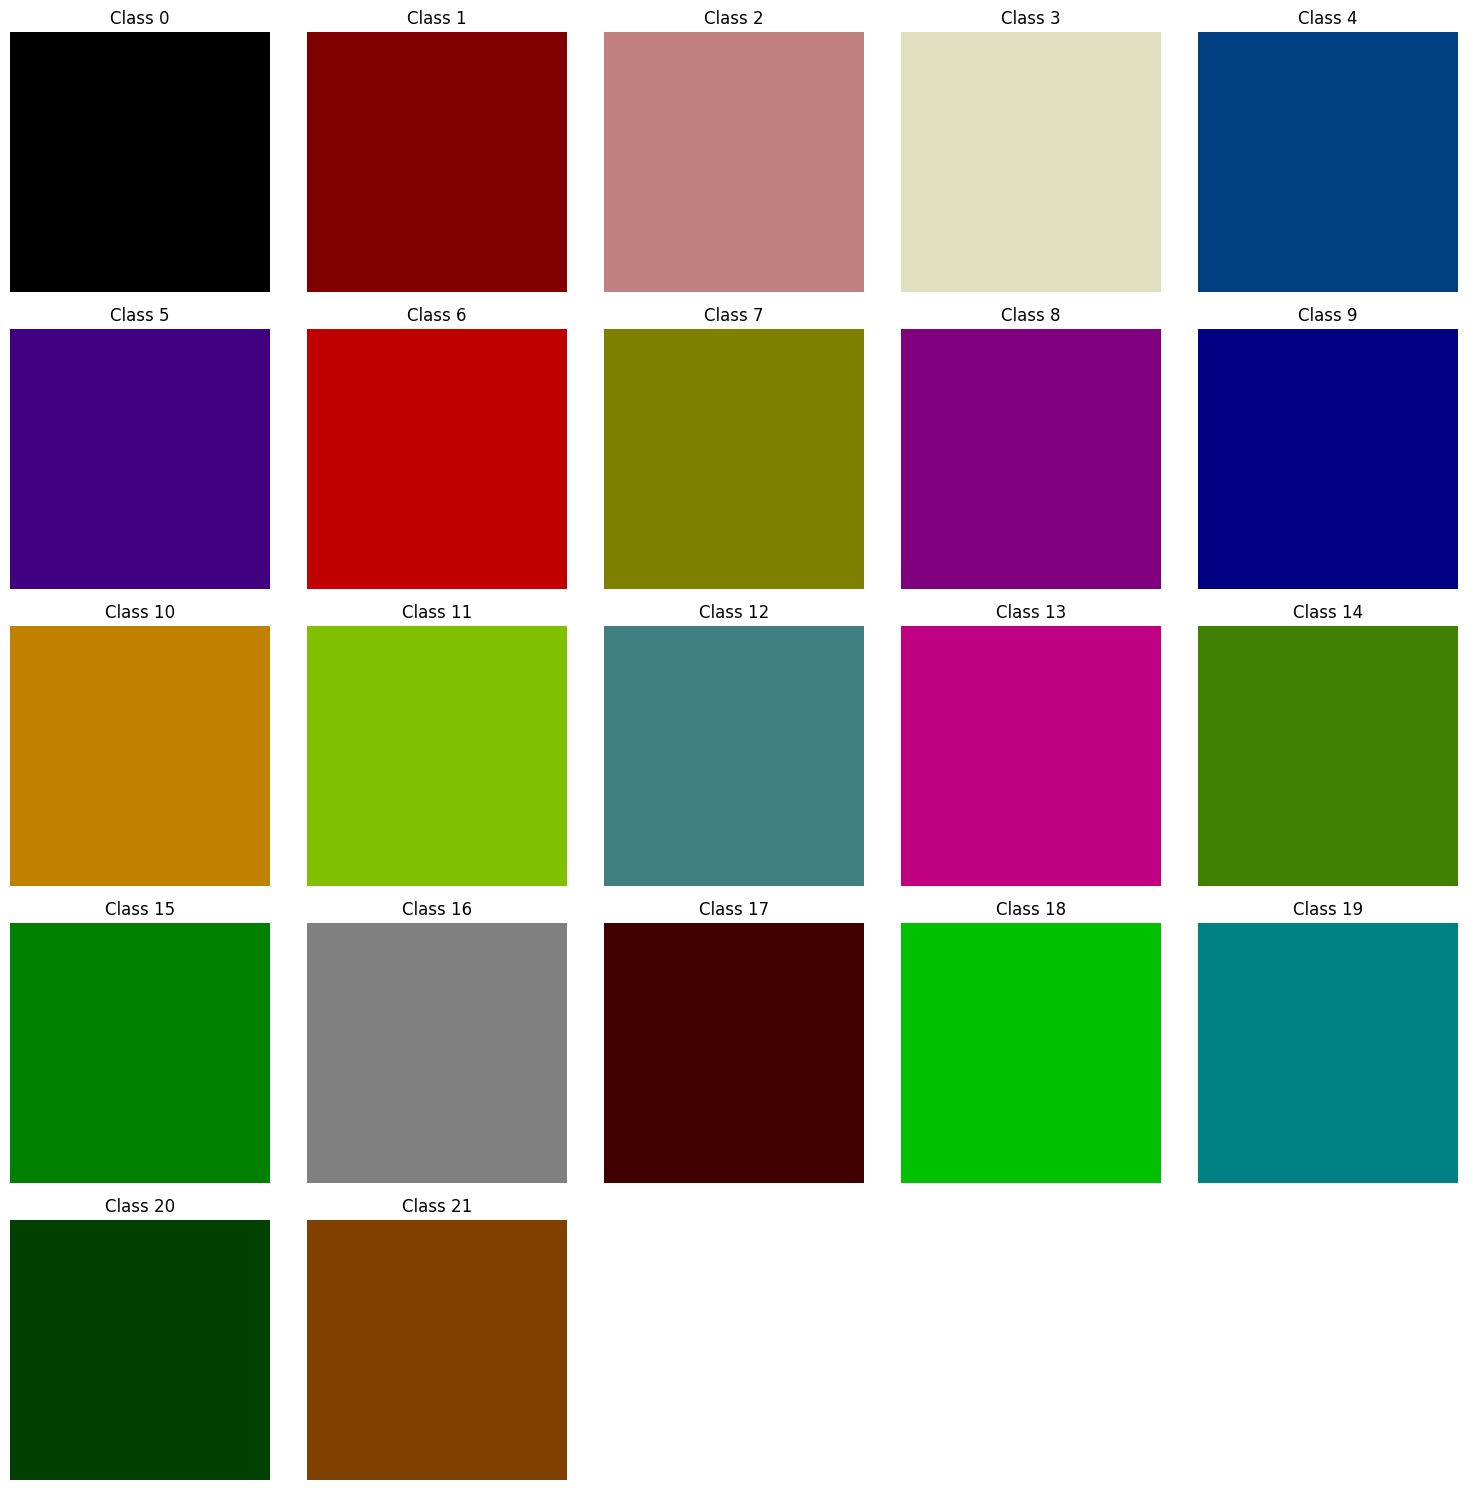

In [91]:
# 5행 5열의 서브플롯 생성
plt.figure(figsize=(15, 15))
for class_id, color in inverse_mapping.items():
    ax = plt.subplot(5, 5, class_id + 1)
    ax.set_title(f"Class {class_id}")
    ax.imshow(np.full((10, 10, 3), color, dtype=np.uint8))  # 색상으로 채운 작은 이미지 생성
    ax.axis('off')

# 나머지 빈 서브플롯 숨기기
for i in range(len(inverse_mapping) + 1, 26):
    ax = plt.subplot(5, 5, i)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [92]:
np.array(resized['mask']).shape

(224, 224, 3)

In [93]:
# 컬러 시맨틱 세그멘테이션 마스크를 정수로 변환
integer_mask = map_color_mask_to_integer(np.array(resized['mask']), class_color_mapping)
integer_mask.shape

(224, 224)

In [94]:
def map_integer_mask_to_color(integer_mask, reverse_mapping):
    color_mask = np.zeros((integer_mask.shape[0], integer_mask.shape[1], 3), dtype=np.uint8)
    for row in range(integer_mask.shape[0]):
        for col in range(integer_mask.shape[1]):
            class_idx = integer_mask[row, col]
            color = reverse_mapping[class_idx]
            # 컬러 값을 [0, 255] 범위로 스케일링
            scaled_color = np.clip(color, 0, 255)
            color_mask[row, col] = scaled_color

    return color_mask

restored_color_mask = map_integer_mask_to_color(integer_mask, inverse_mapping)

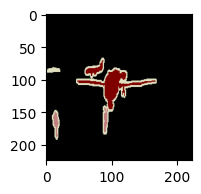

In [95]:
plt.subplot(1, 3, 2)
plt.imshow(restored_color_mask)

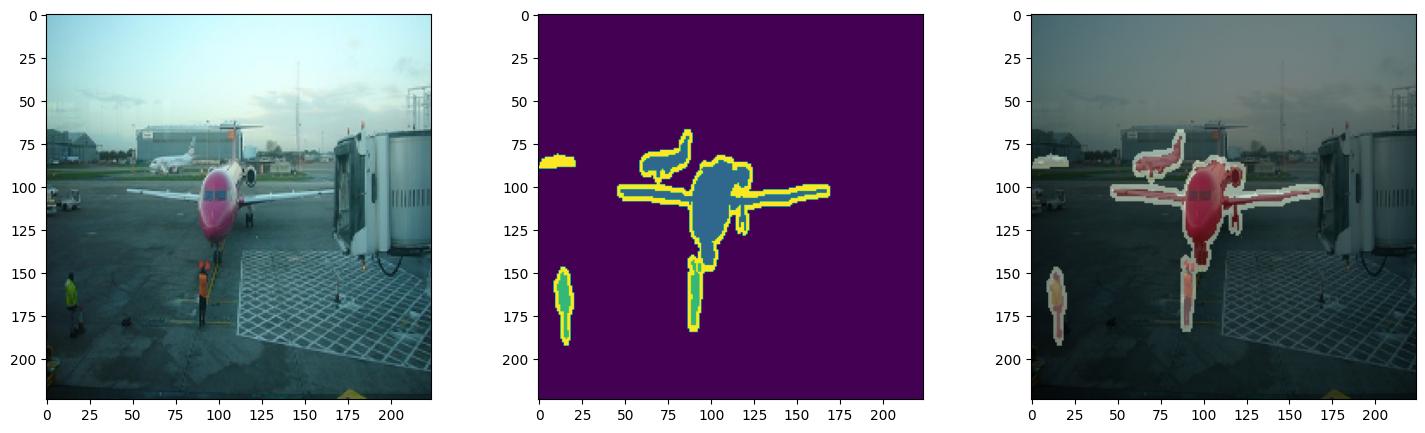

In [96]:
plt.figure(figsize = (18,5))
plt.subplot(1, 3, 1)
plt.imshow(resized["image"])
plt.subplot(1, 3, 2)
plt.imshow(integer_mask)
plt.subplot(1, 3, 3)
plt.imshow(Image.blend(Image.fromarray(resized["image"]),Image.fromarray(restored_color_mask), alpha=0.5))
plt.show()

In [97]:
import os
import math
import random
import numpy as np
from glob import glob
from skimage.io import imread
from PIL import Image
from datasets import DatasetDict
from io import BytesIO
from tensorflow.keras.utils import to_categorical
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self , batch_size=16, img_size=(224, 224, 3), output_size=(224, 224),
                 is_train=True, is_val=False, augmentation=None):
        '''
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_val = is_val
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        self.data = self.load_dataset().to_list()

    def load_dataset(self):
        dataset = load_dataset("nateraw/pascal-voc-2012")
        dataset = concatenate_datasets([dataset["train"], dataset["val"]])
        shuffled_dataset = dataset.shuffle(seed=42)

        # 데이터셋 분할 비율 설정
        train_ratio = 0.7
        val_ratio = 0.2
        test_ratio = 0.1

        # 훈련, 검증, 테스트 세트로 분할
        split_datasets = shuffled_dataset.train_test_split(test_size=(val_ratio + test_ratio))
        test_dataset = split_datasets['test'].train_test_split(test_size=test_ratio / (val_ratio + test_ratio))

        # 최종적으로 분할된 데이터셋
        data = DatasetDict({
            'train': split_datasets['train'],
            'validation': test_dataset['train'],
            'test': test_dataset['test']
        })

        if self.is_train:
            return data['train']
        elif self.is_val:
            return data['validation']
        else:
            return data['test']
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 인덱스에 맞는 데이터 배치를 가져옵니다.
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_data = self.data[start:end]

        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size[:2]])
        for i, data in enumerate(batch_data):
            img, mask = data["image"]["bytes"], data["mask"]["bytes"]
            image = Image.open(BytesIO(img))
            mask = Image.open(BytesIO(mask))
            _input = np.array(image)
            _output = np.array(mask)
            dataset = {'image': _input, 'mask': _output}
            augmented = self.augmentation(**dataset) if self.augmentation else dataset

            integer_mask = map_color_mask_to_integer(augmented['mask'], class_color_mapping)
            # unique_values, counts = np.unique(integer_mask, return_counts=True)

            # 고유한 값들의 개수 출력
            # num_unique_values = len(unique_values)
            # print(unique_values)
            # print("Number of unique values:", num_unique_values)
            # _output = to_categorical(integer_mask, num_classes=22)
            # outputs[i] = _output 
            outputs[i] = integer_mask 
            image_array = augmented["image"] / 255.0
            inputs[i] = image_array

        return inputs, outputs



    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train:
            np.random.shuffle(self.indexes)
        return self.indexes


In [98]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = DataGenerator(
    augmentation=augmentation,
)
val_generator = DataGenerator(
    augmentation=test_preproc,
    is_train = False,
    is_val = True
)
test_generator = DataGenerator(
    augmentation=test_preproc,
    is_train = False,
    is_val = False
)

In [99]:
train_generator.batch_size,val_generator.batch_size,test_generator.batch_size

(16, 16, 16)

In [100]:
len(train_generator),len(val_generator),len(test_generator) # *16 해야 데이터 수 근사

(128, 37, 19)

In [101]:
for image, mask in train_generator:
        sample_image, sample_mask = image, mask
        break
sample_image.shape, sample_mask.shape

((16, 224, 224, 3), (16, 224, 224))

In [102]:

import matplotlib.pyplot as plt
import tensorflow as tf

def display(display_list, titles=[], display_string=None):
    ''' displays list of images/masks'''
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = display_list[i]
        if i == 0:  # If it's the image
            plt.imshow(tf.keras.preprocessing.image.array_to_img(img_arr))
        else:  # If it's the mask
            plt.imshow(img_arr)
            unique_values, counts = np.unique(img_arr, return_counts=True)
            print(unique_values)
            restored_color_mask2 = map_integer_mask_to_color(img_arr, inverse_mapping)
            plt.imshow(restored_color_mask2)
            
            
    
    plt.show()

def show_image_from_dataset(dataset, n_show=2):
    for i in range(n_show):
        for image, mask in dataset:
            sample_image, sample_mask = image, mask
            break
        display([sample_image[i], sample_mask[i]], titles=['Image', 'True Mask'])


>>>>>> Train Image
[0. 3. 5.]


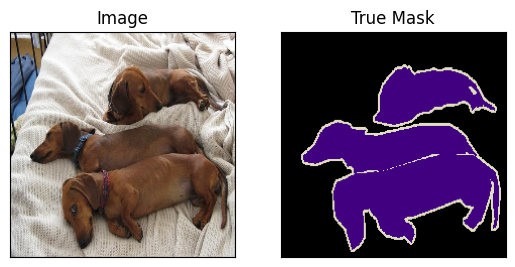

[0. 2. 3.]


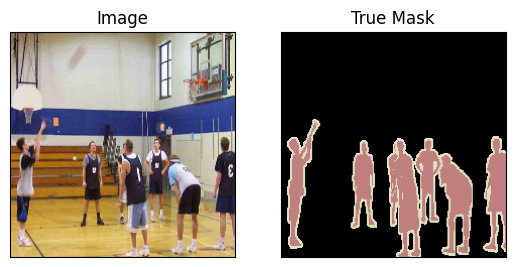

>>>>>> Test Image
[0. 2. 3. 6.]


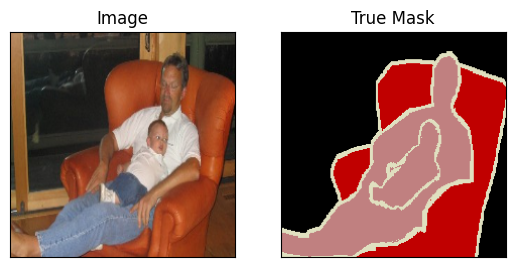

[0. 3. 6.]


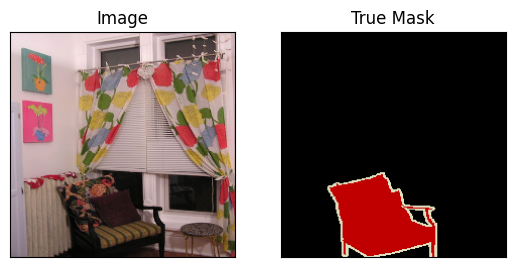

In [103]:
# display an image from the train set

print('>>>>>> Train Image')
show_image_from_dataset(train_generator)
# display an image from the test set
print('>>>>>> Test Image')
show_image_from_dataset(test_generator)

In [104]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [105]:
import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt




from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import utils

In [106]:
def conv_block(filters, x):
    x = Conv2D(filters, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)
    x = Conv2D(filters, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)
    return x
def encoder(filters, x) :
    x = conv_block(filters, x)
    pool = MaxPooling2D(pool_size =(2,2))(x)
    return x, pool
def decoder(filters, x, concat):
    x = Conv2DTranspose(filters, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x)
    x = concatenate([concat, x], axis=3)
    x = conv_block(filters, x)
    return x
def get_outputs(x):
    x = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)     
    x = Conv2D(22, 1, activation='softmax')(x)
    return x

In [107]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [108]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, UpSampling2D, concatenate, Conv2D, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.models import Model
def build_unet_with_backbone(input_shape=(224, 224, 3), num_classes=22):
    inputs = Input(input_shape)

    # 백본 모델 사용 (ResNet50 예시)
    backbone = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # 인코더 레이어 선택
    layer_names = ["conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block6_out"]
    encoder_outputs = [backbone.get_layer(name).output for name in layer_names]

    # 브릿지
    bridge = backbone.output

    # 디코더 시작
    x = bridge
    for i, f in enumerate([512, 256, 128, 64, 32]):  # 32 필터 추가
        x = Conv2DTranspose(f, (3, 3), strides=(2, 2), padding="same")(x)
        if i < len(encoder_outputs):
            skip_output = encoder_outputs[-(i + 1)]
            x = tf.image.resize(x, skip_output.shape[1:3])
            x = concatenate([x, skip_output])  # Skip connection
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # 최종 레이어
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    # 모델 구성
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 모델 생성


In [109]:
from tensorflow_examples.models.pix2pix import pix2pix
IMG_HEIGHT = 224    
IMG_WIDTH  = 224    
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False)

# use the output of listed layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# build the feature extraction model (encoder)
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
# we'll not change the parameter of the decoder
down_stack.trainable = False
# build the upsampling model (decoder)
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [110]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = inputs

    # downsampling and extract features 
    skips = down_stack(x)
    x = skips[-1]
    # layers to establish skip connections in the encoder model
    skips = reversed(skips[:-1])

    # establish skip connections between layers of encoder and decoder
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # the last layer 
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [90]:
OUTPUT_CHANNELS = 22
unet = unet_model(OUTPUT_CHANNELS)
unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_3 (Functional)        [(None, 112, 112, 96),       1841984   ['input_5[0][0]']             
                              (None, 56, 56, 144),                                                
                              (None, 28, 28, 192),                                                
                              (None, 14, 14, 576),                                                
                              (None, 7, 7, 320)]                                                  
                                                                                            

In [91]:

MODEL_PATH = './UNET_mobile.keras'

In [113]:
callbacks = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_PATH,
    save_best_only = True,
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1
)

In [112]:
EPOCHS=10

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
unet.compile(optimizer = optimizer, loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [94]:
batch_size = 16
unet_history = unet.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator) ,
    epochs=EPOCHS,
    callbacks = [callbacks]
)

Epoch 1/10
128/128 [==============================] - ETA: 0s - loss: 1.8301 - accuracy: 0.5846
Epoch 1: val_accuracy improved from -inf to 0.70692, saving model to ./UNET_mobile.keras


/usr/local/lib/python3.11/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


128/128 [==============================] - 121s 897ms/step - loss: 1.8301 - accuracy: 0.5846 - val_loss: 1.3136 - val_accuracy: 0.7069
Epoch 2/10
128/128 [==============================] - ETA: 0s - loss: 1.2195 - accuracy: 0.7061
Epoch 2: val_accuracy improved from 0.70692 to 0.71364, saving model to ./UNET_mobile.keras
128/128 [==============================] - 115s 895ms/step - loss: 1.2195 - accuracy: 0.7061 - val_loss: 1.1670 - val_accuracy: 0.7136
Epoch 3/10
128/128 [==============================] - ETA: 0s - loss: 1.0925 - accuracy: 0.7285
Epoch 3: val_accuracy improved from 0.71364 to 0.73120, saving model to ./UNET_mobile.keras
128/128 [==============================] - 115s 897ms/step - loss: 1.0925 - accuracy: 0.7285 - val_loss: 1.0620 - val_accuracy: 0.7312
Epoch 4/10
128/128 [==============================] - ETA: 0s - loss: 1.0019 - accuracy: 0.7452
Epoch 4: val_accuracy improved from 0.73120 to 0.75959, saving model to ./UNET_mobile.keras
128/128 [======================

In [95]:
batch_size = 16
unet_history2 = unet.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator) ,
    epochs=40,
    callbacks = [callbacks]
)

Epoch 1/40
128/128 [==============================] - ETA: 0s - loss: 0.6352 - accuracy: 0.8224
Epoch 1: val_accuracy improved from 0.82714 to 0.83633, saving model to ./UNET_mobile.keras
128/128 [==============================] - 116s 905ms/step - loss: 0.6352 - accuracy: 0.8224 - val_loss: 0.5796 - val_accuracy: 0.8363
Epoch 2/40
128/128 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.8313
Epoch 2: val_accuracy improved from 0.83633 to 0.84672, saving model to ./UNET_mobile.keras
128/128 [==============================] - 114s 894ms/step - loss: 0.5989 - accuracy: 0.8313 - val_loss: 0.5524 - val_accuracy: 0.8467
Epoch 3/40
128/128 [==============================] - ETA: 0s - loss: 0.5644 - accuracy: 0.8409
Epoch 3: val_accuracy improved from 0.84672 to 0.84815, saving model to ./UNET_mobile.keras
128/128 [==============================] - 114s 894ms/step - loss: 0.5644 - accuracy: 0.8409 - val_loss: 0.5294 - val_accuracy: 0.8482
Epoch 4/40
128/128 [===========

In [154]:
print('asd')

asd


In [ ]:
import json

# 훈련 기록을 JSON으로 변환
history_dict = unet_history.history
history_dict2 = {"epoch": list(range(len(history_dict["loss"]))) , **history_dict}
history_json = json.dumps(history_dict2, indent=4)

# JSON 파일로 저장
with open("unet_history.json", "w") as json_file:
    json_file.write(history_json)


In [ ]:
with open("unet_history.json", "r") as json_file:
    history_json = json.load(json_file)

In [ ]:
!pip install --upgrade aiffel7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.2
    Uninstalling keras-3.0.2:
      Successfully uninstalled keras-3.0.2
  Attempting uninstall: aiffel7
    Found existing installation: aiffel7 0.5.4
    Uninstalling aiffel7-0.5.4:
      Successfully uninstalled aiffel7-0.5.4

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [32]:
from tensorflow.keras.models import load_model

DATA_PATH =  '.'
MODEL_PATH = DATA_PATH +'/UNET_mobile.keras'
# 모델 파일 경로
model_path = MODEL_PATH

# 모델 로드
model = load_model(model_path)

2024-01-11 16:31:50.627613: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 16:31:50.721176: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 16:31:50.725178: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [33]:
unet=model

1/1 [==============================] - 0s 19ms/step


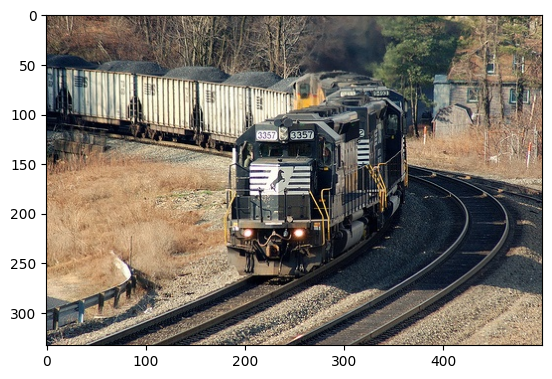

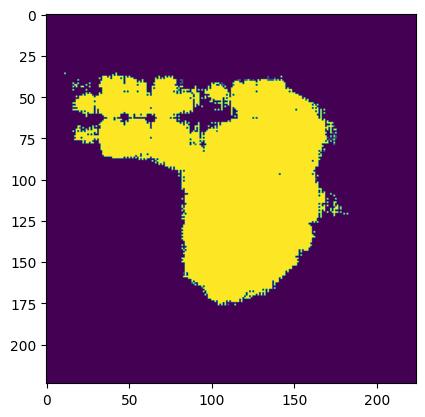

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def create_segmentation_map(model, image, input_size=(224, 224)):
    """
    모델과 이미지를 받아서 세그멘테이션 맵을 생성하는 함수.

    :param model: 학습된 모델.
    :param image: 세그멘테이션을 수행할 이미지.
    :param input_size: 모델에 입력하기 전에 이미지를 조정할 크기.
    :return: 세그멘테이션 맵.
    """
    
    # 이미지 전처리
    resized_image = tf.image.resize(image, input_size)
    resized_image = resized_image / 255

    input_image = np.expand_dims(resized_image, axis=0)  # 배치 차원 추가

    # 모델을 통해 세그멘테이션 예측 수행
    prediction = model.predict(input_image)

    # 예측 결과를 이미지로 변환
    predicted_image = np.argmax(prediction, axis=-1) 
    predicted_image = predicted_image[0, :, :] 

    return predicted_image

# 사용 예시
# model = ... # 학습된 모델을 로드합니다.
# image = ... # 세그멘테이션을 수행할 이미지를 로드합니다.
segmentation_map = create_segmentation_map(unet, np.array(dataset[10]["image"]) )
plt.imshow(dataset[10]["image"])
plt.show()
# 세그멘테이션 맵 시각화
plt.imshow(segmentation_map)
plt.show()

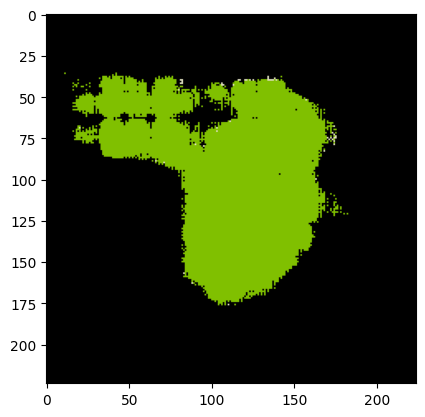

[ 0  3 11] [38175    50 11951]


In [19]:

restored_color_mask2 = map_integer_mask_to_color(segmentation_map, inverse_mapping)
plt.imshow(restored_color_mask2)
plt.show()
restored_color_mask2.shape
unique_values, counts = np.unique(segmentation_map, return_counts=True)

print(unique_values,counts)


In [20]:
unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_3 (Functional)        [(None, 112, 112, 96),       1841984   ['input_5[0][0]']             
                              (None, 56, 56, 144),                                                
                              (None, 28, 28, 192),                                                
                              (None, 14, 14, 576),                                                
                              (None, 7, 7, 320)]                                                  
                                                                                            

배경을 제외한 예측값 형태: (1, 224, 224, 21)
tf.Tensor(4.708547, shape=(), dtype=float32)
(1, 224, 224, 22)
(224, 224, 22)
(224, 224, 1)
[ 0.0000000e+00 -1.7486716e-05  8.0320177e-07  5.8552173e-06
  3.2000585e-07  4.4963684e-07  1.1465945e-06  1.6079894e-06
 -1.3719491e-06  3.6333341e-07  1.0926918e-06  4.2271213e-07
  2.9237771e-07  6.7536172e-07  1.0596008e-06  3.0355892e-07
  2.8674705e-07  3.2048058e-07  1.6375955e-06  2.6170054e-07
  1.2270909e-06  7.3252522e-07]
[[0.09948599 0.10359881 0.11431126 ... 0.19683333 0.1618239  0.14838277]
 [0.11908211 0.12420058 0.13753243 ... 0.23222245 0.19547157 0.18136185]
 [0.14864123 0.15527667 0.17255966 ... 0.28560403 0.24622631 0.23110808]
 ...
 [0.30165464 0.33312798 0.41510507 ... 0.3496646  0.41064176 0.43405262]
 [0.2324104  0.25575972 0.3165765  ... 0.27931836 0.2746724  0.27288866]
 [0.18650518 0.2044687  0.25125736 ... 0.23268257 0.18453196 0.16604556]]


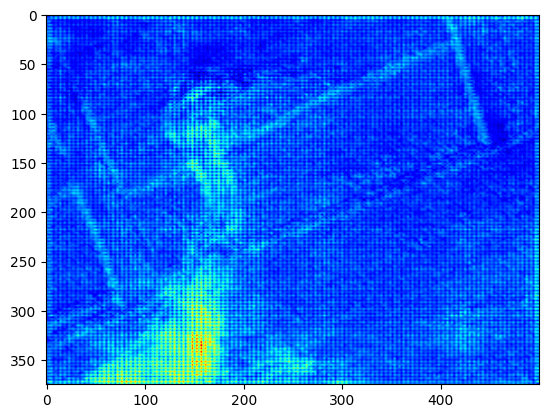

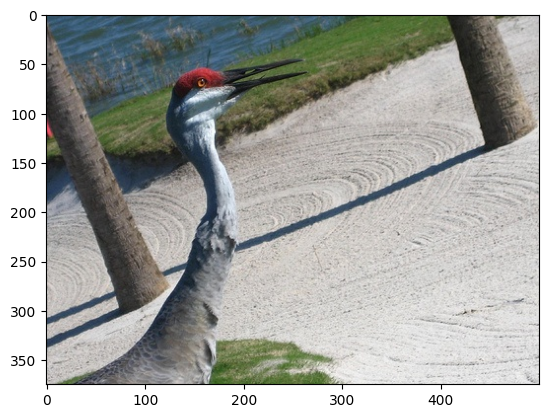

In [56]:
import cv2 
import copy
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = np.array(input['image'])
    mask = np.array(input['mask'])
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    integer_mask= map_color_mask_to_integer(mask, class_color_mapping)
    integer_mask= tf.expand_dims(integer_mask, -1)
    integer_mask = tf.image.resize(integer_mask, [224, 224])
    integer_mask= tf.squeeze(integer_mask, -1)
    
    return image, integer_mask
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = np.array(item['image']).shape[1]
    height = np.array(item['image']).shape[0]
    img_tensor, mask_tensor = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(tf.expand_dims(img_tensor, 0))
        # 배경 클래스 제외
        non_background_predictions = predictions[:, :, :, 1:]
        # 예시 출력
        print("배경을 제외한 예측값 형태:", non_background_predictions.shape)
        # 가정: `true_labels`는 해당 이미지의 실제 레이블을 포함하고 있음
        # `from_logits=True`는 모델 출력이 확률이 아닌 로짓임을 나타냄
        loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        mask_tensor= tf.expand_dims(mask_tensor, -1)
        mask_tensor= tf.expand_dims(mask_tensor, 0)
        loss = loss_function(mask_tensor, non_background_predictions)
        print(loss)
        predictions = tf.squeeze(predictions, axis=0)
        print(conv_output.shape)
        print(predictions.shape)
        predicted_classes = tf.argmax(predictions, axis=2)
        predicted_classes= tf.expand_dims(predicted_classes, -1)
        
        print(predicted_classes.shape)
        output=conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    print(weights)
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image
grad_cam_image = generate_grad_cam(unet, 'conv2d_transpose_13', dataset[3])
print(grad_cam_image)
plt.imshow(grad_cam_image, cmap='jet') 
plt.show()
plt.imshow(dataset[3]["image"])
plt.show()

In [69]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
        )(block_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [70]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = tf.keras.layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = tf.keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [71]:
def DeeplabV3(image_size, num_classes):
    model_input = tf.keras.Input(shape=(image_size, image_size, 3))
    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = tf.keras.layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = tf.keras.layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = tf.keras.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    model = tf.keras.Model(inputs=model_input, outputs=model_output)
    
    return model

In [72]:
img_height = 224
img_width = 224
num_channels = 3
filters = 32
n_classes = 22

model = DeeplabV3(img_height, num_classes=22)
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [114]:

MODEL_PATH = './deeplabv3.keras'
callbacks = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_PATH,
    save_best_only = True,
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1
)

In [118]:
EPOCHS=10

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer = optimizer, loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [119]:
batch_size = 16
unet_history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator) ,
    epochs=EPOCHS,
    callbacks = [callbacks]
)

Epoch 1/10


2024-01-11 20:59:41.512146: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4828c75170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-11 20:59:41.512158: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-11 20:59:41.527495: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704974381.706566    2167 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 [==============================] - ETA: 0s - loss: 1.3257 - accuracy: 0.6936
Epoch 1: val_accuracy improved from -inf to 0.72450, saving model to ./deeplabv3.keras
128/128 [==============================] - 151s 911ms/step - loss: 1.3257 - accuracy: 0.6936 - val_loss: 1.5309 - val_accuracy: 0.7245
Epoch 2/10
  8/128 [>.............................] - ETA: 1:35 - loss: 0.8857 - accuracy: 0.7577

KeyboardInterrupt: 